In [1]:
import warnings
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Flatten, Input
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanSquaredError

# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import math
warnings.filterwarnings('ignore')

In [2]:
tf.compat.v1.reset_default_graph() 

In [3]:
SAMSUNG = yf.download('005930.KS', 
                      start='2002-01-01', 
                      end='2022-12-08', 
                      progress=False)
all_data = SAMSUNG[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

SAMSUNG


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-01,5580.0,5580.0,5580.0,5580.0,4193.598633,0
2002-01-02,5660.0,6160.0,5620.0,6160.0,4629.492676,57100000
2002-01-03,6160.0,6160.0,6160.0,6160.0,4629.492676,0
2002-01-04,6380.0,6410.0,6290.0,6380.0,4794.832031,50470000
2002-01-07,6260.0,6430.0,6170.0,6360.0,4779.801758,51455000
...,...,...,...,...,...,...
2022-12-01,63100.0,63200.0,62300.0,62600.0,62600.000000,16631445
2022-12-02,62500.0,62500.0,60400.0,60400.0,60400.000000,15331184
2022-12-05,60900.0,61100.0,60000.0,60300.0,60300.000000,13767787


In [4]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2016-10-21':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

In [5]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2016-10-20'].iloc[:,0:1].values
    ts_test  = all_data['2016-10-21':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
 
    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train = np.array(X_train) 
    y_train = np.array(y_train) 

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2016-10-20'], all_data["Adj Close"]['2016-10-21':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [6]:
X_train, Y_train, X_test, sc = ts_train_test_normalize(all_data,30,3)

X_train_see= pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
Y_train_see= pd.DataFrame(Y_train)
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")
pd.concat([Y_train_see])
Y_train[3699]=np.append(Y_train[3699],0.0)



There are 3700 samples in the training data
There are 1502 samples in the test data


In [7]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
for i in range(len(X_train)):
    if len(X_train[i]) != 30:
        print(len(i))
        
for i in range(len(Y_train)):
    if len(Y_train[i]) != 3:
        print(len(i))
        
for i in range(len(X_test)):
    if len(X_test[i]) != 30:
        print(len(i))
Y_train = np.array([np.array(val) for val in Y_train])       
print(X_train.dtype)
print(Y_train.dtype)
print(X_test.dtype)
    

(3700, 30, 1)
(3700,)
(1502, 30, 1)
float64
float64
float64


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 19,075
Trainable params: 19,075
Non-trainable params: 0
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and ins

In [17]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):

    from keras.utils import plot_model
    from keras.layers import concatenate

    inputs = Input(shape=(X_train.shape[1],1))
    hidden1 = LSTM(64)(inputs)
    hidden2 = Dense(32, activation='relu')(hidden1)
    flat2 = Flatten()(hidden2)
    output = Dense(3, activation='relu')(flat2)
    my_LSTM_model = Model(inputs=inputs, outputs=output)
    # summarize layers
    print(my_LSTM_model.summary())

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=100,batch_size=10, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [ ]:
# from keras.utils import plot_model
# from keras.layers import concatenate

# # input layer
# inputs = Input(shape=((X_train.shape[1],1),1))
# # first feature extractor
# stockLstm = LSTM(64, activation='relu')(inputs)
# stock1 = Dense(32, activation='relu')(stockLstm)
# stock2 = Dense(32, activation='relu')(stock1)
# stock_finish = Dense(32, activation='relu')(stock2)
# flat1 = Flatten()(stock_finish)
# # second feature extractor
# newsLstm = LSTM(64, activation='relu')(inputs)
# news1 = Dense(30, activation='relu')(newsLstm)
# news2 = Dense(30, activation='relu')(news1)
# news_finish = Dense(30, activation='relu')(news2)
# flat2 = Flatten()(news_finish)

# # merge feature extractors
# merge = concatenate([flat1, flat2])

# # interpretation layer
# hidden1 = Dense(10, activation='relu')(merge)

# # prediction output
# output = Dense(3, activation='sigmoid')(hidden1)

# model = Model(inputs=inputs, outputs=output)
# # summarize layers
# print(model.summary())
# # plot graph
# plot_model(model, to_file='multiple_inputs.png')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 19,075
Trainable params: 19,075
Non-trainable params: 0
_________________________________________________________________
None
47/47 [==============================] - 0s 3ms/st

(25234238.0, <AxesSubplot:xlabel='Date'>)

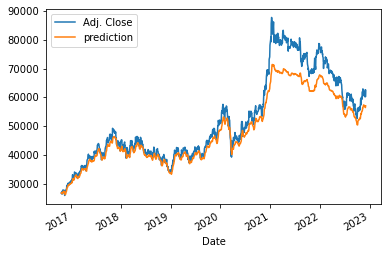

In [18]:
my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, Y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)  

In [ ]:
import numpy as np

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))

def MSE(true, pred):
    return np.mean(np.square(true-pred))

In [ ]:
RMSE_value= "{:.2f}".format(np.sqrt(MSE(X_test, LSTM_prediction[0][:])))
print("RMSE = ",RMSE_value)

MAE_value= "{:.2f}".format(MAE(X_test, LSTM_prediction[0][:]))
print("MAE = ",MAE_value)

MAPE_value= "{:.2f}".format(MAPE(X_test, LSTM_prediction[0][:]))
print("MAPE = ",MAPE_value)

SMAPE_value= "{:.2f}".format(SMAPE(X_test, LSTM_prediction[0][:]))
print("SMAPE = ",SMAPE_value)